<a href="https://colab.research.google.com/github/Kryptera-K/ADBE-CCI-Momentum-Rising-BullBear-Strategy/blob/main/ADBE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "ADBE"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("ADBE_clean.csv", index=False)
df

/tmp/ipython-input-764472526.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,16.274670,16.755618,15.948866,16.693560,7384400
2000-01-04,14.909398,16.336729,14.878369,15.638578,7813200
2000-01-05,15.204175,15.576522,14.459481,14.459481,14927200
2000-01-06,15.328290,15.545492,15.049030,15.250718,10221200
2000-01-07,16.072981,16.072981,15.111084,15.281743,8253200
...,...,...,...,...,...
2025-10-22,354.089996,360.190002,352.869995,355.480011,3436000
2025-10-23,354.119995,354.350006,348.709991,352.510010,2408100
2025-10-24,353.519989,358.100006,353.290009,357.209991,2016900


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BEAR_EMA_PERIOD = 13
BEAR_POWER_LEVEL = 0
BEAR_POWER_SHIFT = 5
BULL_EMA_PERIOD = 13
BULL_LEVEL = 0
CCI_LEVEL = 0
CCI_PERIOD = 14
CCI_SHIFT = 5
CCI_SHIFT_2 = 10
MOMENTUM_LEVEL = 100
MOMENTUM_PERIOD = 10

# -------------------------
# Indicator Functions
# -------------------------

def cci_higher_than(df, period=CCI_PERIOD, level=CCI_LEVEL):
    df['CCI_main'] = calculate_cci(df, period)['CCI']
    return df['CCI_main'] > level


def calculate_cci(df, period=CCI_PERIOD):
    """
    Calculate Commodity Channel Index (CCI).
    """
    df = df.copy()
    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    # SMA of TP
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    # Mean Deviation
    df['MeanDev'] = df['TP'].rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    # CCI
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df


def momentum_rising(df, period=MOMENTUM_PERIOD):
    df = calculate_momentum(df, period)
    return df["Momentum"].diff() > 0


def calculate_momentum(df, period=MOMENTUM_PERIOD):
    """
    Classic momentum: current close / close n periods ago * 100
    """
    df = df.copy()
    df["Momentum"] = df["Close"] / df["Close"].shift(period) * 100
    return df


def bears_power_cross_above(df, period = BEAR_EMA_PERIOD, level=BEAR_POWER_LEVEL):
    df = calculate_bears_power(df, period)
    return (df['Bears_Power'].shift(1) <= level) & (df['Bears_Power'] > level)


def calculate_bears_power(df, period=BEAR_EMA_PERIOD):
    """Calculate Bears Power indicator and return updated DataFrame"""
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    df['Bears_Power'] = df['Low'] - df['EMA']
    return df


def bull_power_change_down(df, EMA_PERIOD=BULL_EMA_PERIOD):
    df = calculate_bull_power(df, EMA_PERIOD)
    return df['Bull_Power'] < df['Bull_Power'].shift(1)


def calculate_bull_power(df, EMA_PERIOD=BULL_EMA_PERIOD):
    """
    Calculate Bull Power indicator.
    Bull Power = High - EMA(Close)
    """
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=EMA_PERIOD, adjust=False).mean()
    df['Bull_Power'] = df['High'] - df['EMA']
    return df



# -------------------------
# Entry conditions
# -------------------------

df["CCI_Higher_Than_Level"] = cci_higher_than(df)
df["Momentum_Rising"] = momentum_rising(df)

# -------------------------
# Exit conditions
# -------------------------

df["BearP_Cross_Above_0"] = bears_power_cross_above(df)
df["BullP_Downward"] = bull_power_change_down(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'CCI_Higher_Than_Level',
    'Momentum_Rising',
]
exit_conditions = [
    'BearP_Cross_Above_0',
    'BullP_Downward',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                 2000-01-03 00:00:00
End                                   2025-10-28 00:00:00
Period                                 6495 days 00:00:00
Start Value                                      100000.0
End Value                                  3024937.825982
Total Return [%]                              2924.937826
Benchmark Return [%]                           2054.15411
Max Gross Exposure [%]                              100.0
Total Fees Paid                                81453.8201
Max Drawdown [%]                                67.984063
Max Drawdown Duration                  1524 days 00:00:00
Total Trades                                           51
Total Closed Trades                                    50
Total Open Trades                                       1
Open Trade PnL                             -763314.144632
Win Rate [%]                                         66.0
Best Trade [%]                                  93.558449
Worst Trade [%

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-10-28 00:00:00
Period                         6495 days 00:00:00
Start Value                              100000.0
End Value                          2154153.858013
Total Return [%]                      2054.153858
Benchmark Return [%]                  2054.153858
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        79.832281
Max Drawdown Duration          1518 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     2054153.858013
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-1901350642.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


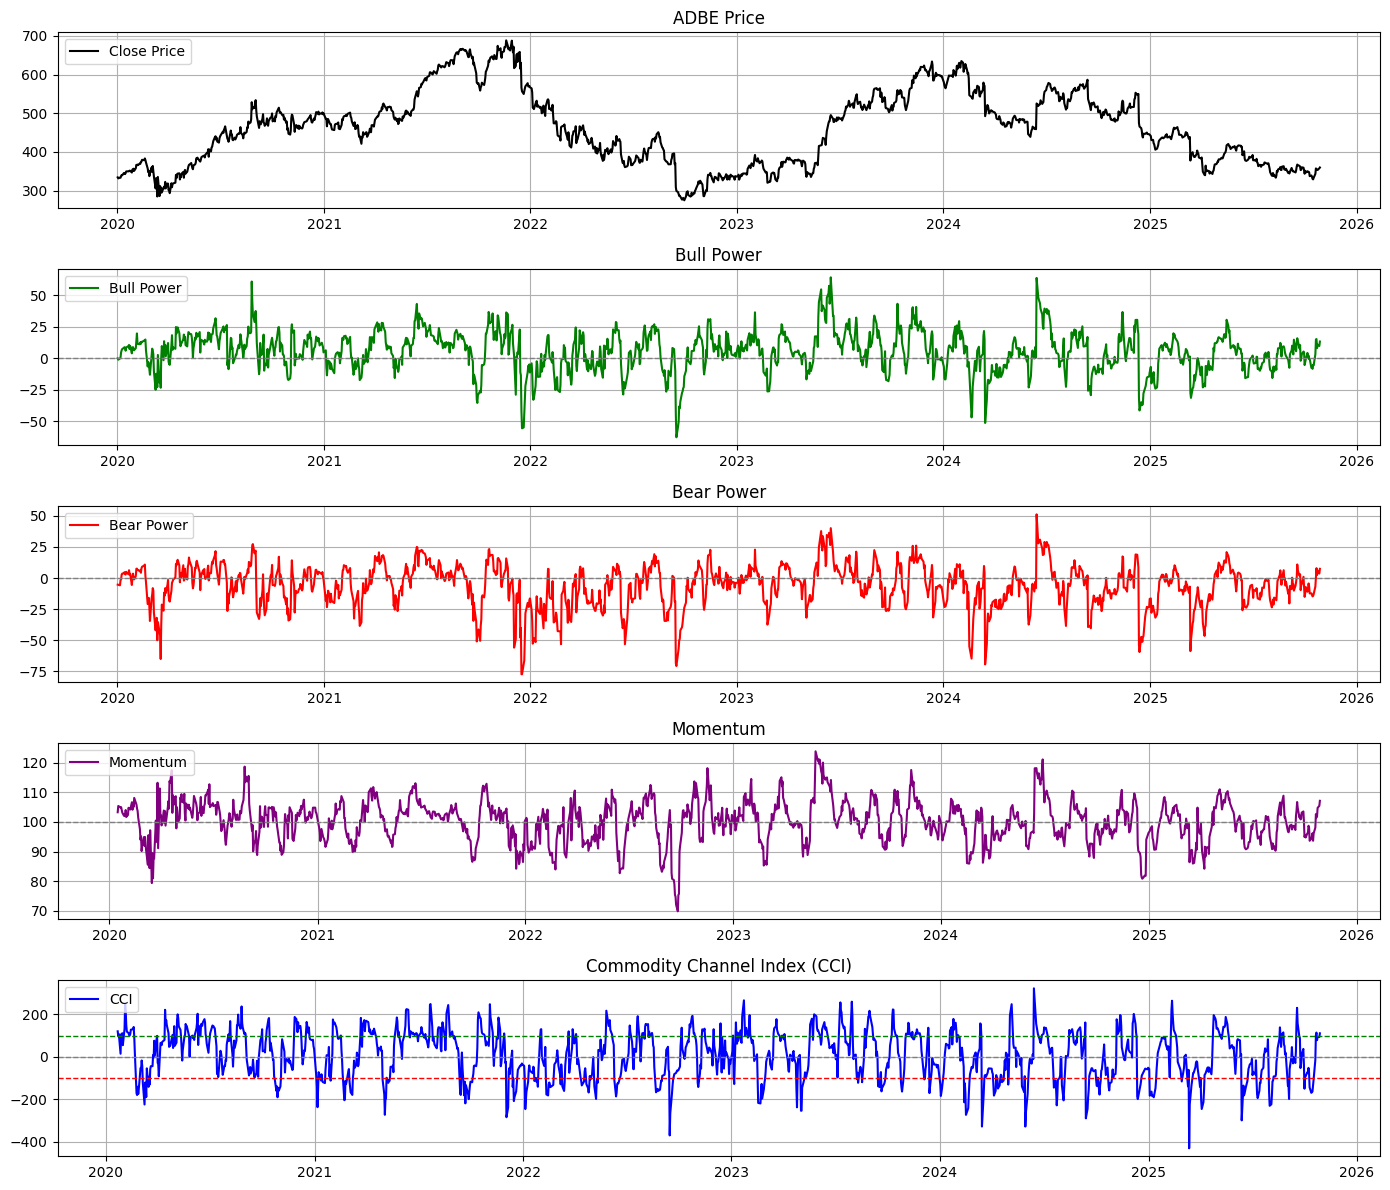

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------

symbol = "ADBE"
start_date = "2020-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Parameters
# -------------------------

BEAR_EMA_PERIOD = 13
BEAR_POWER_LEVEL = 0
BULL_EMA_PERIOD = 13
BULL_LEVEL = 0
CCI_LEVEL = 0
CCI_PERIOD = 14
MOMENTUM_PERIOD = 10

# -------------------------
# Indicator Functions
# -------------------------

def calculate_cci(df, period=CCI_PERIOD):
    df = df.copy()
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    df['MeanDev'] = df['TP'].rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df

def calculate_momentum(df, period=MOMENTUM_PERIOD):
    df = df.copy()
    df['Momentum'] = df['Close'] / df['Close'].shift(period) * 100
    return df

def calculate_bears_power(df, period=BEAR_EMA_PERIOD):
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    df['Bears_Power'] = df['Low'] - df['EMA']
    return df

def calculate_bull_power(df, EMA_PERIOD=BULL_EMA_PERIOD):
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=EMA_PERIOD, adjust=False).mean()
    df['Bull_Power'] = df['High'] - df['EMA']
    return df

# -------------------------
# Calculate Indicators
# -------------------------

df = calculate_bears_power(df, BEAR_EMA_PERIOD)
df = calculate_bull_power(df, BULL_EMA_PERIOD)
df = calculate_cci(df, CCI_PERIOD)
df = calculate_momentum(df, MOMENTUM_PERIOD)

# -------------------------
# Plot Indicators
# -------------------------

plt.figure(figsize=(14, 12))

# 1. Price + EMA
plt.subplot(5, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price', color='black')
plt.title(f'{symbol} Price')
plt.legend(loc='upper left')
plt.grid(True)

# 2. Bull Power
plt.subplot(5, 1, 2)
plt.plot(df.index, df['Bull_Power'], label='Bull Power', color='green')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Bull Power')
plt.legend(loc='upper left')
plt.grid(True)

# 3. Bear Power
plt.subplot(5, 1, 3)
plt.plot(df.index, df['Bears_Power'], label='Bear Power', color='red')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Bear Power')
plt.legend(loc='upper left')
plt.grid(True)

# 4. Momentum
plt.subplot(5, 1, 4)
plt.plot(df.index, df['Momentum'], label='Momentum', color='purple')
plt.axhline(100, color='gray', linestyle='--', linewidth=1)
plt.title('Momentum')
plt.legend(loc='upper left')
plt.grid(True)

# 5. CCI
plt.subplot(5, 1, 5)
plt.plot(df.index, df['CCI'], label='CCI', color='blue')
plt.axhline(100, color='green', linestyle='--', linewidth=1)
plt.axhline(-100, color='red', linestyle='--', linewidth=1)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Commodity Channel Index (CCI)')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()
